<a href="https://colab.research.google.com/github/CheilaBaiao/Pantanal/blob/main/5)HOTSPOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title R3-1 — Setup (libs, Drive, paths, config)
%pip -q install numpy pandas geopandas shapely rasterio rioxarray xarray tqdm pyyaml joblib

import os, re, glob, json, time, yaml, math, warnings
from pathlib import Path
import numpy as np, pandas as pd
from tqdm.auto import tqdm
import geopandas as gpd

from joblib import Memory
memory = Memory(location="/content/.joblib_cache", verbose=0)

# Montar Drive
from google.colab import drive
try:
    drive.mount('/content/drive')
except Exception as e:
    print("Aviso ao montar Drive:", e)

# Pastas-base
BASE_DIR   = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index")
OUT_DIR    = BASE_DIR / "outputs"
LOG_DIR    = OUT_DIR / "logs"
QC_DIR     = OUT_DIR / "qc"
CACHE_DIR  = OUT_DIR / "cache_nb3"              # cache de agregações 30m→300m, etc.
TMP_DIR    = OUT_DIR / "tmp_nb3"                # temporários
for d in (OUT_DIR, LOG_DIR, QC_DIR, CACHE_DIR, TMP_DIR): d.mkdir(parents=True, exist_ok=True)

# Config
CONFIG_FP = BASE_DIR / "config.yaml"
assert CONFIG_FP.exists(), f"config.yaml não encontrado em {CONFIG_FP}"
CONFIG = yaml.safe_load(open(CONFIG_FP))

CRS_EPSG      = int(CONFIG.get("crs_epsg", 31983))
BOUNDARY_PATH = CONFIG.get("boundary_path"); assert BOUNDARY_PATH and Path(BOUNDARY_PATH).exists()
OPT_FOLDER    = CONFIG.get("gee_drive_folder_optical", "Pantanal_TippingPoints_optical")

# Fontes de dados
MB30_DIR   = Path("/content/drive/MyDrive/Pantanal_TippingPoints_val_mb_bi_30m")  # (1) sua pasta MB 30m
OPT_ROOTS  = [Path("/content/drive/MyDrive"), Path("/content/drive/My Drive")]
OPT_DIRS   = [r / OPT_FOLDER for r in OPT_ROOTS]
MERGE_DIRS = [r / f"{OPT_FOLDER}_merged" for r in OPT_ROOTS]

# Onde salvar os agregados MB 300m (cache)
MB300_DIR  = OUT_DIR / "mb_bi_300m_cache"
MB300_DIR.mkdir(parents=True, exist_ok=True)

print("✔ Config carregada | EPSG:", CRS_EPSG)
print("✔ MB 30m:", MB30_DIR)
print("✔ MB 300m (cache):", MB300_DIR)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.4 MB/s eta 0:00:00
Mounted at /content/drive
✔ Config carregada | EPSG: 31983
✔ MB 30m: /content/drive/MyDrive/Pantanal_TippingPoints_val_mb_bi_30m
✔ MB 300m (cache): /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/mb_bi_300m_cache


In [ ]:
# @title INSPEÇÃO — Valores únicos nos rasters de TTR_status por índice
import numpy as np, rasterio as rio
from pathlib import Path
import pandas as pd

ROOT    = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
REC_DIR = ROOT/'index'/'outputs'/'recovery_nb3'

STATUS_RASTERS = {
    'NDVI': REC_DIR/'ttr_status_NDVI.tif',
    'EVI' : REC_DIR/'ttr_status_EVI.tif',
    'NBR' : REC_DIR/'ttr_status_NBR.tif',
    'VOD' : REC_DIR/'ttr_status_VOD.tif',
}

print("Arquivos de status:")
for k, fp in STATUS_RASTERS.items():
    print(f"  {k}: {fp}  | existe? {fp.exists()}")

summary = []
for idx, fp in STATUS_RASTERS.items():
    if not fp.exists():
        print(f"\n⚠️ {idx}: arquivo não encontrado, pulando.")
        continue
    with rio.open(fp) as ds:
        arr = ds.read(1).astype('float32')
        nd = ds.nodata
        if nd is not None:
            arr = np.where(arr == nd, np.nan, arr)
    vals, counts = np.unique(arr[np.isfinite(arr)], return_counts=True)
    print(f"\n=== {idx} — valores únicos (excluindo NaN) ===")
    for v, c in zip(vals, counts):
        print(f"  valor {int(v)} → {c} pixels")
        summary.append({'index': idx, 'value': int(v), 'count': int(c)})

df_status = pd.DataFrame(summary).sort_values(['index','value'])
display(df_status)


Arquivos de status:
  NDVI: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/ttr_status_NDVI.tif  | existe? True
  EVI: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/ttr_status_EVI.tif  | existe? True
  NBR: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/ttr_status_NBR.tif  | existe? True
  VOD: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/ttr_status_VOD.tif  | existe? True

=== NDVI — valores únicos (excluindo NaN) ===
  valor 1 → 877482 pixels
  valor 2 → 11991 pixels
  valor 3 → 8100 pixels

=== EVI — valores únicos (excluindo NaN) ===
  valor 1 → 873409 pixels
  valor 2 → 16064 pixels
  valor 3 → 8100 pixels

=== NBR — valores únicos (excluindo NaN) ===
  valor 1 → 859840 pixels
  valor 2 → 29630 pixels
  valor 3 → 8100 pixels

=== VOD — valores únicos (excluindo NaN) ===
  valor 1 → 694989 pixels
  valor 2 → 150508 pixels
  valor 3 → 8102 pixels


,index,value,count
3,EVI,1,873409
4,EVI,2,16064
5,EVI,3,8100
6,NBR,1,859840
7,NBR,2,29630
8,NBR,3,8100
0,NDVI,1,877482
1,NDVI,2,11991
2,NDVI,3,8100
9,VOD,1,694989


In [ ]:
# @title CONFIG — Códigos de status e escolha de classe problemática
from pathlib import Path
import numpy as np, rasterio as rio

ROOT    = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
REC_DIR = ROOT/'index'/'outputs'/'recovery_nb3'
FF_FP   = REC_DIR/'first_fire_yyyymm.tif'
AOI_MASK  = ROOT/'Pantanal_mask_300m.tif'   # se não existir, será ignorado

STATUS_RASTERS = {
    'NDVI': REC_DIR/'ttr_status_NDVI.tif',
    'EVI' : REC_DIR/'ttr_status_EVI.tif',
    'NBR' : REC_DIR/'ttr_status_NBR.tif',
    'VOD' : REC_DIR/'ttr_status_VOD.tif',
}

INDICES = ['NDVI','EVI','NBR','VOD']

# 🔧 Ajuste estes códigos conforme o resultado da célula de inspeção:
STATUS_CODES = {
    'RECOVERED': [1],      # ex.: [1]
    'PARTIAL'  : [2],      # ex.: [2]
    'NONREC'   : [3],      # ex.: [3]
    'CENSORED' : [4],      # se houver
}

# 👉 Parâmetro chave: o que conta como "problema de recuperação"?
INCLUDE_PARTIAL = True    # True → PARTIAL + NONREC; False → apenas NONREC

if INCLUDE_PARTIAL:
    PROBLEM_CODES = STATUS_CODES['PARTIAL'] + STATUS_CODES['NONREC']
    print("→ Pixel problemático = status em PARTIAL + NONREC", PROBLEM_CODES)
else:
    PROBLEM_CODES = STATUS_CODES['NONREC']
    print("→ Pixel problemático = status em NONREC", PROBLEM_CODES)

# --- Funções de utilidade ---
def read_raster(fp):
    with rio.open(fp) as ds:
        arr = ds.read(1)
        prof = ds.profile
    nd = prof.get('nodata', None)
    if nd is not None:
        arr = np.where(arr == nd, np.nan, arr).astype('float32')
    else:
        arr = arr.astype('float32')
    return arr, prof

# first_fire (para ano de 1º fogo)
ff, ff_prof = read_raster(FF_FP)
burned = np.isfinite(ff) & (ff.astype('float64') > 0)
years_ff = (ff // 100).astype('int32')  # YYYY

# AOI (Pantanal_mask_300m ou equivalente, se existir)
if AOI_MASK.exists():
    with rio.open(AOI_MASK) as ds:
        aoi = (ds.read(1) == 1)
else:
    aoi = np.isfinite(ff)

domain = burned & aoi
print("✓ Domain (burned & AOI) definido.")


→ Pixel problemático = status em PARTIAL + NONREC [2, 3]
✓ Domain (burned & AOI) definido.


/tmp/ipython-input-116617444.py:52: RuntimeWarning: invalid value encountered in cast
  years_ff = (ff // 100).astype('int32')  # YYYY


In [ ]:
# --- CENSURA por janela incompleta (2019–2021) ---
CENSORED_YEARS = {2019, 2020, 2021}

# years_ff: raster (int) com ano do 1º fogo (mesma grade de 'domain')
# se ainda não tiver, derive de first_fire_yyyymm: years_ff = (ff // 100).astype('int32')
censored_mask = np.isfinite(years_ff) & np.isin(years_ff, list(CENSORED_YEARS))

# domínio realmente válido para contar/plotar
valid_domain = domain & (~censored_mask)


✔ Figura 2×4 salva em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/figure_TTRstatus_2x4_categorical_DUAL.png


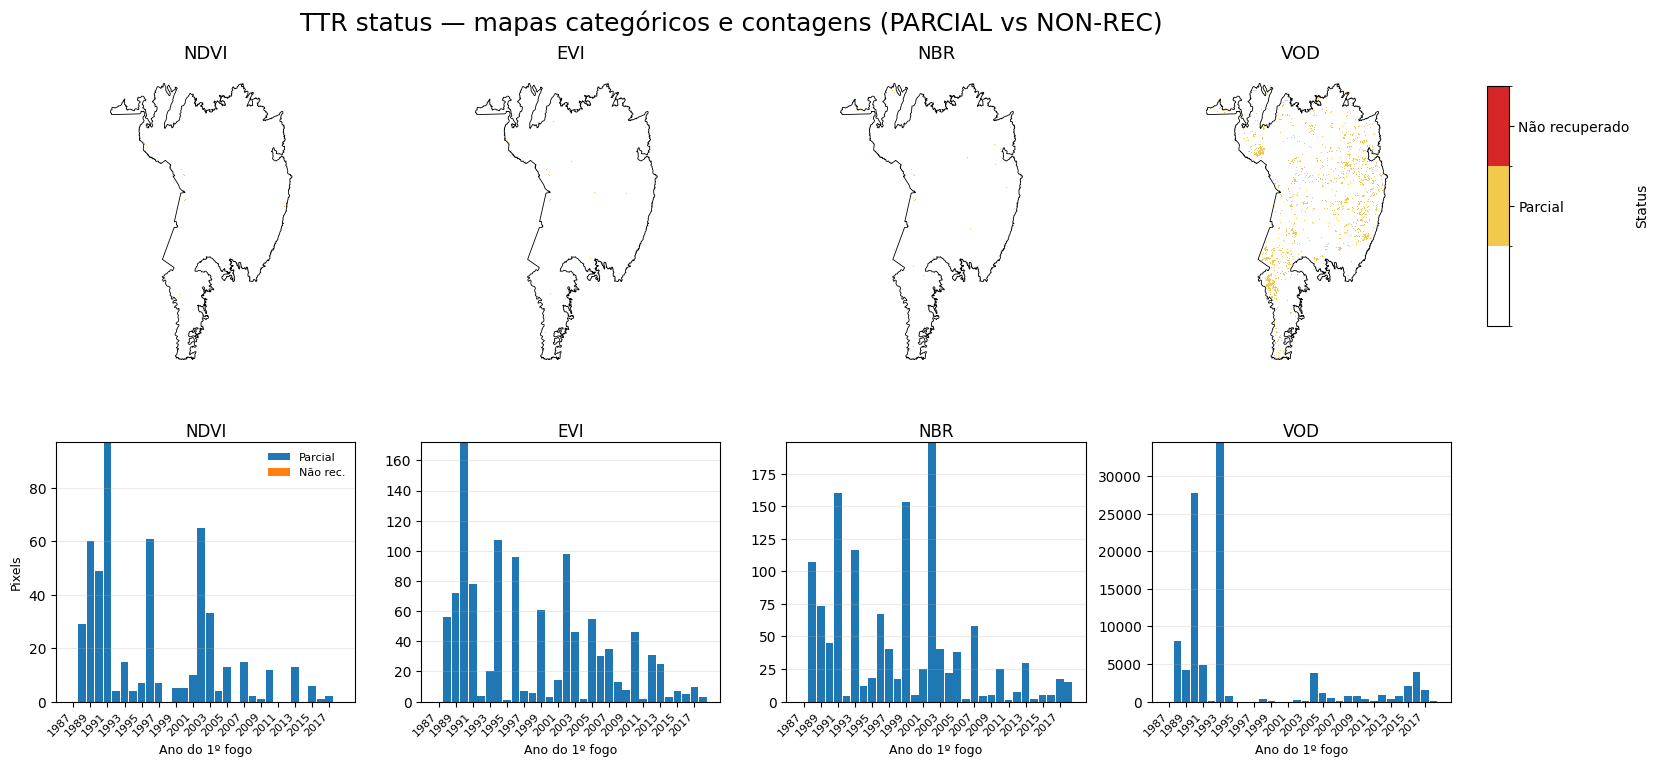

In [ ]:
# @title 2×4 — Mapas CATEGÓRICOS (PARCIAL vs NON-REC) + barras por ano (stack/normal)
import numpy as np, pandas as pd, rasterio as rio
import matplotlib.pyplot as plt, matplotlib as mpl
import geopandas as gpd
from rasterio.transform import xy
from pathlib import Path

# ---------- Parâmetros de desenho ----------
DRAW_MODE = "DUAL"   # "DUAL" => duas cores (PARCIAL e NON-REC) | "BINARY" => problemático vs não
OUT_DIR2x4 = ROOT/'index'/'outputs'/'compare_nb3'
OUT_DIR2x4.mkdir(parents=True, exist_ok=True)

# ---------- Utilidades ----------
def raster_extent_from_profile(prof):
    """extent = (xmin, xmax, ymin, ymax) p/ imshow"""
    h, w = prof['height'], prof['width']
    tfm = prof['transform']
    xmin, ymax = xy(tfm, 0, 0)
    xmax, ymin = xy(tfm, h-1, w-1)
    return (xmin, xmax, ymin, ymax), tfm, prof.get('crs', None)

# ---------- Ler 1 raster de referência p/ extent/CRS ----------
ref_idx = next(i for i in INDICES if STATUS_RASTERS[i].exists())
with rio.open(STATUS_RASTERS[ref_idx]) as ds_ref:
    ref_prof = ds_ref.profile
extent, ref_tfm, ref_crs = raster_extent_from_profile(ref_prof)

# Contorno do Pantanal (para plotar por cima)
pant = gpd.read_file(ROOT/'Pantanal.shp').to_crs(ref_crs)

# ---------- Construir ARR_CLASS por índice ----------
# Convenção da classe:
# 0 = não problemático (ou fora do domínio)
# 1 = PARCIAL    (STATUS_CODES['PARTIAL'])
# 2 = NON-REC    (STATUS_CODES['NONREC'])
# NaN = fora do AOI ou fora da área queimada (fica branco)
PARTIAL_CODES = set(STATUS_CODES.get('PARTIAL', []))
NONREC_CODES  = set(STATUS_CODES.get('NONREC',  []))

arr_class_by_idx = {}
for idx in INDICES:
    fp = STATUS_RASTERS[idx]
    if not fp.exists():
        continue
    with rio.open(fp) as ds:
        st  = ds.read(1).astype('float32')
        prof = ds.profile
        nd = prof.get('nodata', None)
        if nd is not None:
            st = np.where(st == nd, np.nan, st)

    # base: 0
    arrc = np.zeros_like(st, dtype='float32')

    # marca PARCIAL e NONREC
    is_partial = np.isin(st, list(PARTIAL_CODES))
    is_nonrec  = np.isin(st, list(NONREC_CODES))

    arrc[is_partial] = 1.0
    arrc[is_nonrec]  = 2.0

    # fora do domínio (não queimado ou fora AOI) → NaN para ficar branco
    arrc[~valid_domain] = np.nan
    arr_class_by_idx[idx] = (arrc, prof)

# ---------- Barras por ano ----------
valid_years = np.unique(years_ff[valid_domain & np.isfinite(years_ff)])
valid_years = valid_years[(valid_years >= 1987) & (valid_years <= 2021) & (~np.isin(valid_years, list(CENSORED_YEARS)))]

rows = []
for idx, (arrc, _) in arr_class_by_idx.items():
    for y in valid_years:
        sel = (years_ff == y) & valid_domain
        n_partial = int(((arrc == 1) & sel).sum())
        n_nonrec  = int(((arrc == 2) & sel).sum())
        n_prob    = n_partial + n_nonrec
        rows.append(dict(index=idx, year=int(y),
                         partial_pixels=n_partial, nonrec_pixels=n_nonrec,
                         problem_pixels=n_prob))

df = pd.DataFrame(rows)

# ---------- Figura 2×4 ----------
fig, axes = plt.subplots(
    2, 4, figsize=(18, 8),
    gridspec_kw={'height_ratios':[1.12, 1.0]}
)

mode_str = "PARCIAL vs NON-REC" if DRAW_MODE=="DUAL" else ("PROBLEM (PARCIAL+NON-REC)" if INCLUDE_PARTIAL else "PROBLEM (NON-REC only)")
title = f'TTR status — mapas categóricos e contagens ({mode_str})'
fig.suptitle(title, fontsize=18, y=0.975)
plt.subplots_adjust(top=0.90, hspace=0.30, wspace=0.22, right=0.90)

# colormaps discretos
if DRAW_MODE == "DUAL":
    # 0 branco (não problemático), 1 âmbar (parcial), 2 vermelho (non-rec)
    cmap = mpl.colors.ListedColormap(["#FFFFFF", "#F2C94C", "#D62728"])
    norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    cbar_ticks = [1, 2]
    cbar_labels = ["Parcial", "Não recuperado"]
else:
    # 0 branco, 1 vermelho (problemático)
    cmap = mpl.colors.ListedColormap(["#FFFFFF", "#D62728"])
    norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)
    cbar_ticks = [1]
    cbar_labels = ["Problemático"]

# Linha 1 — Mapas
for j, idx in enumerate(INDICES):
    ax = axes[0, j]
    if idx not in arr_class_by_idx:
        ax.text(0.5, 0.5, f"(sem {idx})", ha='center', va='center')
        ax.axis('off')
        continue
    arrc, prof = arr_class_by_idx[idx]

    # opcionalmente reduzir a classe para binário quando DRAW_MODE=="BINARY"
    show = arrc.copy()
    if DRAW_MODE == "BINARY":
        show = np.where(show==2, 1, show)            # nonrec=1
        show = np.where(show==1, 1 if INCLUDE_PARTIAL else 0, show)  # parcial vira 1 só se INCLUDE_PARTIAL=True
        # os demais (0/NaN) ficam iguais

    im = ax.imshow(show, origin='upper', cmap=cmap, norm=norm, extent=extent, interpolation='nearest')
    # contorno do Pantanal
    pant.boundary.plot(ax=ax, color='k', linewidth=0.6)
    ax.set_title(idx, fontsize=13, pad=8)
    ax.axis('off')

# colorbar comum
cax = fig.add_axes([0.92, 0.58, 0.012, 0.30])
cb  = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=cbar_ticks)
cb.ax.set_yticklabels(cbar_labels)
cb.set_label('Status', fontsize=10)

# Linha 2 — Barras (empilhadas no modo DUAL; simples no modo BINARY)
for j, idx in enumerate(INDICES):
    ax = axes[1, j]
    g = df[df['index']==idx].sort_values('year')
    if g.empty:
        ax.axis('off'); continue

    years = g['year'].to_numpy()
    if DRAW_MODE == "DUAL":
        y1 = g['partial_pixels'].to_numpy()
        y2 = g['nonrec_pixels'].to_numpy()
        ax.bar(years, y1, width=0.9, edgecolor='none', label='Parcial')
        ax.bar(years, y2, width=0.9, edgecolor='none', bottom=y1, label='Não rec.')
    else:
        counts = (g['problem_pixels']).to_numpy()
        ax.bar(years, counts, width=0.9, edgecolor='none', label='Problemático')

    # ticks ímpares
    if years.size:
        ymin, ymax = years.min(), years.max()
        odd_ticks = np.array([yy for yy in range(ymin, ymax+1) if (yy % 2) == 1], dtype=int)
        ax.set_xticks(odd_ticks)
        ax.set_xticklabels(odd_ticks, rotation=45, ha='right', fontsize=8)

    ax.set_title(idx, fontsize=12, pad=4)
    ax.set_xlabel('Ano do 1º fogo', fontsize=9)
    if j == 0:
        ax.set_ylabel('Pixels', fontsize=9)
        ax.legend(frameon=False, fontsize=8)
    ax.grid(True, axis='y', alpha=0.25)

out_png = OUT_DIR2x4/f'figure_TTRstatus_2x4_categorical_{DRAW_MODE}.png'
fig.savefig(out_png, dpi=220, bbox_inches='tight')
print('✔ Figura 2×4 salva em:', out_png)
plt.show()


In [ ]:
# @title Raster único de problema (UNIÃO entre índices) a partir de TTR_status
import numpy as np, rasterio as rio
from pathlib import Path

ROOT    = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
REC_DIR = ROOT/'index'/'outputs'/'recovery_nb3'
CMP_DIR = ROOT/'index'/'outputs'/'compare_nb3'
CMP_DIR.mkdir(parents=True, exist_ok=True)

OUT_UNION_FP = CMP_DIR/'problem_union_from_TTRstatus.tif'

# Usa STATUS_RASTERS, PROBLEM_CODES, FF_FP, AOI_MASK, domain já definidos

# Começa com zero dentro do domain
problem_union = np.zeros_like(ff, dtype='uint8')

for idx, fp in STATUS_RASTERS.items():
    with rio.open(fp) as ds:
        status = ds.read(1).astype('float32')
        nd = ds.nodata
        if nd is not None:
            status = np.where(status == nd, np.nan, status)
    this_prob = np.isin(status, PROBLEM_CODES) & domain
    problem_union[this_prob] = 1

# Fora do AOI / não queimados → 0 (mas podemos marcar como NaN via nodata)
profile = ff_prof.copy()
profile.update(dtype='uint8', count=1, compress='lzw', nodata=0)

with rio.open(OUT_UNION_FP, 'w', **profile) as dst:
    dst.write(problem_union, 1)

print("✔ Raster de problema (UNIÃO) salvo em:", OUT_UNION_FP)


✔ Raster de problema (UNIÃO) salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/problem_union_from_TTRstatus.tif


In [ ]:
# @title Reclassificar TTR_status_{metric}: 1->0 ; 2/3->1
# Mesclar (UNIÃO) e CONTAR quantos índices têm problema
# Elegíveis: first_fire <= 2018; fora do Pantanal = NoData (255)

import numpy as np, rasterio as rio, geopandas as gpd
from rasterio.mask import mask as rio_mask
from pathlib import Path

# --------- Paths ---------
ROOT       = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
RECOV_DIR  = ROOT/'index'/'outputs'/'recovery_nb3'
OUT_DIR    = ROOT/'index'/'outputs'/'compare_nb3'/'reclass_status'
OUT_DIR.mkdir(parents=True, exist_ok=True)

FF_FP      = RECOV_DIR/'first_fire_yyyymm.tif'
PANTANAL_SHP = ROOT/'Pantanal.shp'
STATUS_FPS = {
    'NDVI': RECOV_DIR/'ttr_status_NDVI.tif',
    'EVI' : RECOV_DIR/'ttr_status_EVI.tif',
    'NBR' : RECOV_DIR/'ttr_status_NBR.tif',
    'VOD' : RECOV_DIR/'ttr_status_VOD.tif',
}

# --------- Helpers ---------
def read_as_float(fp):
    with rio.open(fp) as ds:
        arr = ds.read(1).astype('float32')
        prof = ds.profile.copy()
        nd = prof.get('nodata', None)
        if nd is not None:
            arr = np.where(arr == nd, np.nan, arr)
    return arr, prof

def write_u8_like(ofp, arr_u8, ref_prof, nodata=255):
    prof = ref_prof.copy()
    prof.update(count=1, dtype='uint8', nodata=nodata, compress='lzw', BIGTIFF='IF_SAFER')
    with rio.open(ofp, 'w', **prof) as dst:
        dst.write(arr_u8, 1)

def yyyymm_to_year(A):
    Y = np.floor(A/100.0).astype('float32')
    Y[~np.isfinite(A)] = np.nan
    return Y

# --------- Elegibilidade & máscara Pantanal ---------
# first_fire → anos; elegíveis = ano <= 2018
with rio.open(FF_FP) as ds_ff:
    ff = ds_ff.read(1).astype('float32')
    prof = ds_ff.profile.copy()
    nd = prof.get('nodata', None)
    if nd is not None:
        ff = np.where(ff == nd, np.nan, ff)

    # máscara do Pantanal no grid do FF
    gdf = gpd.read_file(PANTANAL_SHP).to_crs(ds_ff.crs)
    geoms = [gdf.unary_union.__geo_interface__]
    pant_mask, _ = rio_mask(ds_ff, geoms, crop=False, filled=True)
    pant_mask = pant_mask[0].astype('float32')
    if nd is not None:
        pant_mask = np.where(pant_mask == nd, np.nan, pant_mask)
    pant_in = np.isfinite(pant_mask)  # True dentro

year = yyyymm_to_year(ff)
eligible = np.isfinite(year) & (year <= 2018) & pant_in  # exclui 2019–2021 e fora do Pantanal

# --------- Reclassificação por índice ---------
bin_maps = {}   # booleanos (True=problema)
for idx, fp in STATUS_FPS.items():
    arr, _ = read_as_float(fp)  # 1=rec, 2=parcial, 3=não-rec, 0/NaN=sem dado
    valid = np.isfinite(arr) & eligible

    # 1 -> 0 ; 2/3 -> 1 ; demais → NaN
    bin_bool = np.full(arr.shape, False, dtype=bool)
    bin_bool[valid & ((arr == 2) | (arr == 3))] = True
    # salva binário reclassificado (0/1 u8; fora do Pantanal/inelegível = 255)
    out_bin = np.full(arr.shape, 255, dtype='uint8')
    out_bin[eligible & np.isfinite(arr)] = (bin_bool[eligible & np.isfinite(arr)]).astype('uint8')

    bin_fp = OUT_DIR/f'ttr_status_{idx}_bin_1isProblem_u8.tif'
    write_u8_like(bin_fp, out_bin, prof)
    print(f'✔ Reclass salvo: {bin_fp}')
    # guarda apenas o booleano sobre a área elegível (fora = False)
    bmask = np.zeros(arr.shape, dtype=bool)
    bmask[eligible] = bin_bool[eligible]
    bin_maps[idx] = bmask

# --------- Mesclas ---------
# UNIÃO: algum índice com problema
union_bool = np.zeros(ff.shape, dtype=bool)
for b in bin_maps.values():
    union_bool |= b

# CONTAGEM: número de índices com problema (0..4)
count_u8 = np.zeros(ff.shape, dtype='uint8')
for b in bin_maps.values():
    count_u8 += b.astype('uint8')

# aplica NoData fora dos elegíveis (255)
union_u8 = np.where(eligible, union_bool.astype('uint8'), 255).astype('uint8')
count_u8  = np.where(eligible, count_u8, 255).astype('uint8')

# salvar
UNION_FP = OUT_DIR/'problem_union_anyIndex_u8.tif'
COUNT_FP = OUT_DIR/'problem_count_0to4_u8.tif'
write_u8_like(UNION_FP, union_u8, prof)
write_u8_like(COUNT_FP, count_u8,  prof)
print(f'✔ União salva:  {UNION_FP}')
print(f'✔ Contagem salva:{COUNT_FP}')

# --------- Relatório rápido ---------
def summarize(name, arr_u8):
    m = arr_u8 != 255
    total = int(m.sum())
    ones  = int((arr_u8 == 1).sum()) if name=='union' else None
    if name=='union':
        print(f'— {name}: elegíveis={total:,} | com problema={ones:,} ({(ones/max(total,1))*100:.2f}%)')
    else:
        # histograma 0..4
        vals, cts = np.unique(arr_u8[m], return_counts=True)
        print(f'— {name}: elegíveis={total:,}')
        for v, c in zip(vals, cts):
            print(f'    {int(v)} índices com problema: {int(c):,}')

summarize('union', union_u8)
summarize('count', count_u8)

print('✓ Fim')


/tmp/ipython-input-2080703269.py:56: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geoms = [gdf.unary_union.__geo_interface__]


✔ Reclass salvo: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/reclass_status/ttr_status_NDVI_bin_1isProblem_u8.tif
✔ Reclass salvo: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/reclass_status/ttr_status_EVI_bin_1isProblem_u8.tif
✔ Reclass salvo: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/reclass_status/ttr_status_NBR_bin_1isProblem_u8.tif
✔ Reclass salvo: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/reclass_status/ttr_status_VOD_bin_1isProblem_u8.tif
✔ União salva:  /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/reclass_status/problem_union_anyIndex_u8.tif
✔ Contagem salva:/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/reclass_status/problem_count_0to4_u8.tif
— union: elegíveis=813,055 | com problema=99,736 (12.27%)
— count: elegíveis=813,055
    0 índices com problema: 713,319
    1 índices com problema: 98,989
    2 índices co

Contagens — 0(OK)=713,319 | 1(problema)=99,736 | 255(NoData)=3,133,121 | válidos=813,055
Problema (UNIÃO) entre válidos: 12.27%


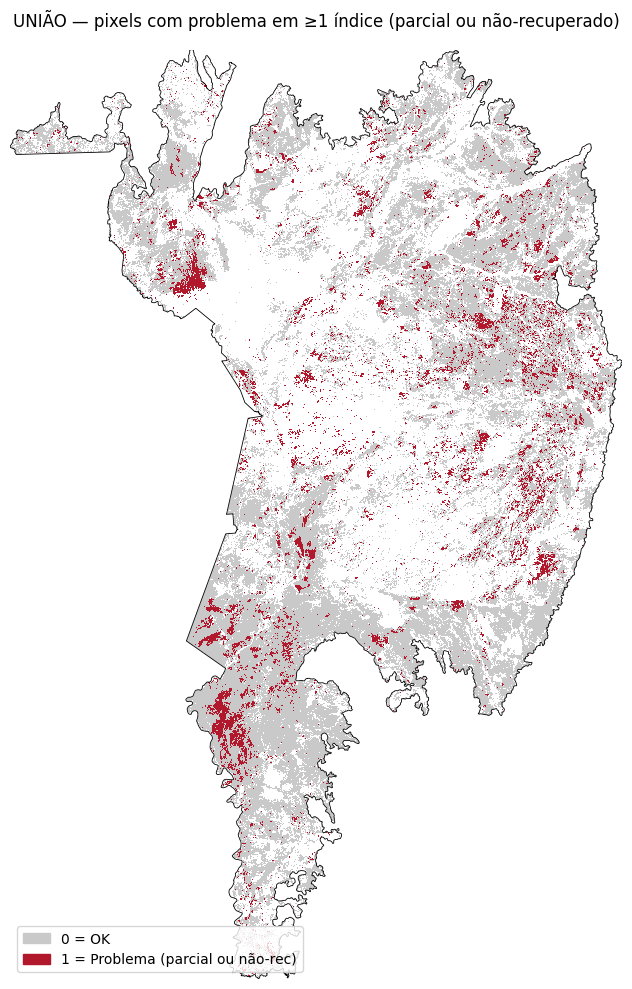

✔ Figura salva em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/reclass_status/problem_union_map.png


In [ ]:
# @title Plot correto da UNIÃO com extent e borda do Pantanal
import numpy as np, matplotlib.pyplot as plt, rasterio as rio, geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm
from pathlib import Path

ROOT         = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
OUT_DIR      = ROOT/'index'/'outputs'/'compare_nb3'/'reclass_status'
UNION_FP     = OUT_DIR/'problem_union_anyIndex_u8.tif'
PANTANAL_SHP = ROOT/'Pantanal.shp'
OUT_PNG      = OUT_DIR/'problem_union_map.png'

assert UNION_FP.exists(), f'Arquivo não encontrado: {UNION_FP}'
assert PANTANAL_SHP.exists(), f'Pantanal.shp não encontrado: {PANTANAL_SHP}'

# --- ler raster (0=ok, 1=problema, 255=NoData/inelegível) ---
with rio.open(UNION_FP) as ds:
    A    = ds.read(1)
    tfm  = ds.transform
    crs  = ds.crs
    H, W = ds.height, ds.width
    # extent (xmin, xmax, ymin, ymax) a partir do affine
    xmin = tfm.c
    ymax = tfm.f
    xmax = xmin + tfm.a * W
    ymin = ymax + tfm.e * H  # tfm.e é negativo em north-up
    extent = (xmin, xmax, ymin, ymax)

# --- contagens ---
vals, cnts = np.unique(A, return_counts=True)
counts = dict(zip(vals.tolist(), cnts.tolist()))
n0 = counts.get(0, 0)     # OK
n1 = counts.get(1, 0)     # problema
nN = counts.get(255, 0)   # NoData / inelegível
nV = n0 + n1
print(f'Contagens — 0(OK)={n0:,} | 1(problema)={n1:,} | 255(NoData)={nN:,} | válidos={nV:,}')
if nV > 0:
    print(f'Problema (UNIÃO) entre válidos: {100*n1/nV:.2f}%')

# --- preparar array para plot (NaN=NoData) ---
show = A.astype('float32')
show[A == 255] = np.nan

# --- borda Pantanal ---
pant = gpd.read_file(PANTANAL_SHP).to_crs(crs)

# --- colormap categórico ---
cmap = ListedColormap([
    '#c9c9c9',  # 0 = OK (cinza visível)
    '#b2182b'   # 1 = Problema (vermelho)
])
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

# --- plot ---
plt.figure(figsize=(7,10))
im = plt.imshow(show, cmap=cmap, norm=norm, extent=extent, origin='upper', interpolation='nearest')
pant.boundary.plot(ax=plt.gca(), color='black', linewidth=0.6)

plt.title('UNIÃO — pixels com problema em ≥1 índice (parcial ou não-recuperado)')
plt.axis('off')

# legenda simples
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='#c9c9c9', label='0 = OK'),
    mpatches.Patch(color='#b2182b', label='1 = Problema (parcial ou não-rec)')
]
plt.legend(handles=legend_handles, loc='lower left', frameon=True)

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=220, bbox_inches='tight')
plt.show()
print('✔ Figura salva em:', OUT_PNG)



Elegíveis: 813,055 | Problemas: 99,736  (12.27%)
✔ TIFs salvos:
 /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/hotspots_from_union/fraction_union_R5km.tif 
 /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/hotspots_from_union/pvals_union_R5km.tif 
 /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/hotspots_from_union/significant_union_R5km_a0.05.tif


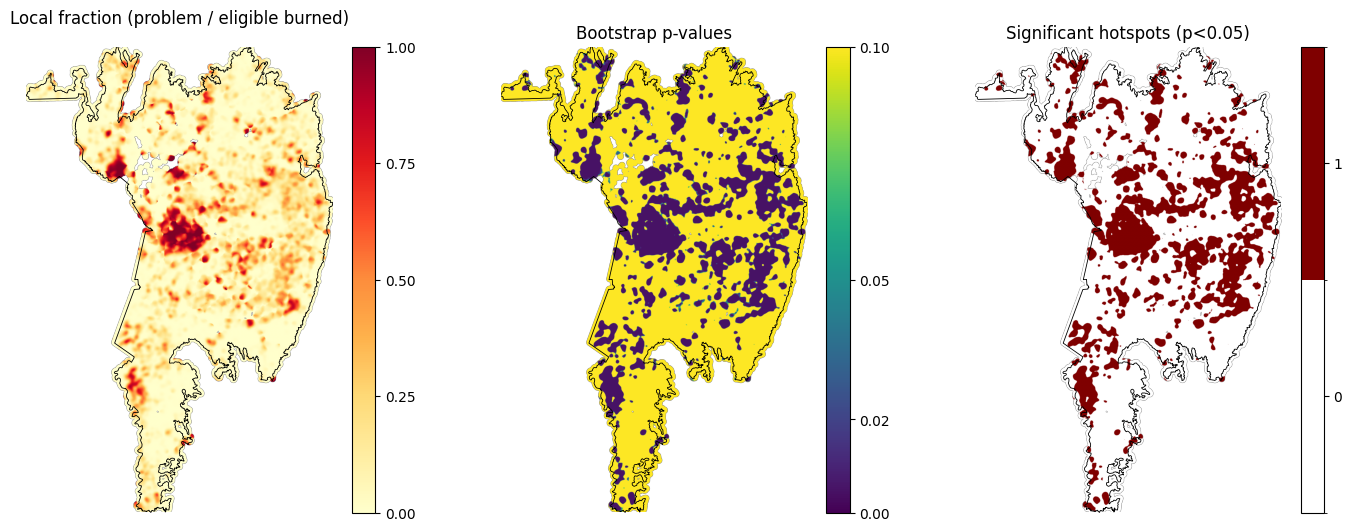

Hotspots significativos: 515,573  • raio=5.0 km • permutações=199


In [ ]:
# @title Hotspots a partir do UNION (0=OK, 1=problema, 255=NoData) — 3 painéis + TIFs
# Usa bootstrap restrito (permutações dentro dos elegíveis) e borda do Pantanal.

import numpy as np, matplotlib.pyplot as plt, gc
import rasterio as rio
from rasterio.features import geometry_mask
import geopandas as gpd
from scipy.signal import convolve2d
from matplotlib.colors import ListedColormap, BoundaryNorm
from pathlib import Path

# ---------------- Parâmetros ----------------
ROOT         = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
UNION_FP     = ROOT/'index'/'outputs'/'compare_nb3'/'reclass_status'/'problem_union_anyIndex_u8.tif'
PANTANAL_SHP = ROOT/'Pantanal.shp'
OUT_DIR      = ROOT/'index'/'outputs'/'compare_nb3'/'hotspots_from_union'
OUT_DIR.mkdir(parents=True, exist_ok=True)

R_KM   = 5.0    # raio da janela
ALPHA  = 0.05   # nível de significância
N_BOOT = 199    # nº de permutações (≥99 recomendado)

assert UNION_FP.exists(), f'Arquivo não encontrado: {UNION_FP}'
assert PANTANAL_SHP.exists(), 'Pantanal.shp não encontrado.'

# ---------------- Utilitários ----------------
def gaussian_disk_kernel(radius_px: int, sigma: float=None):
    r = int(max(1, radius_px))
    if sigma is None: sigma = r/2.0
    y, x = np.ogrid[-r:r+1, -r:r+1]
    mask = (x*x + y*y) <= (r*r)
    K = np.exp(-(x*x + y*y)/(2.0*sigma*sigma)) * mask.astype(float)
    s = K.sum()
    return K/s if s>0 else K

def local_sum(arr: np.ndarray, ker: np.ndarray):
    ok  = np.isfinite(arr)
    val = np.where(ok, arr, 0.0).astype('float32')
    return convolve2d(val, ker, mode='same', boundary='fill', fillvalue=0.0)

def save_tif(fp, arr, ref_profile):
    prof = ref_profile.copy()
    prof.update(dtype='float32', count=1, compress='lzw', nodata=np.nan)
    with rio.open(fp, 'w', **prof) as dst:
        dst.write(arr.astype('float32'), 1)

# ---------------- Leitura & máscaras ----------------
with rio.open(UNION_FP) as ds:
    A   = ds.read(1)
    tfm = ds.transform
    crs = ds.crs
    prof = ds.profile
    H, W = ds.height, ds.width
    xmin, ymax = tfm.c, tfm.f
    xmax, ymin = xmin + tfm.a*W, ymax + tfm.e*H
    extent = (xmin, xmax, ymin, ymax)
    pix_m = abs(tfm.a)

# máscara do Pantanal alinhada ao raster
pant = gpd.read_file(PANTANAL_SHP).to_crs(crs)
mask_pant = geometry_mask(pant.geometry, out_shape=(H,W), transform=tfm, invert=True)  # True = dentro

# elegíveis = dentro do Pantanal & não-NoData (255)
eligible = (A != 255) & mask_pant
problem  = (A == 1) & eligible

n_elig = int(eligible.sum())
n_prob = int(problem.sum())
print(f'Elegíveis: {n_elig:,} | Problemas: {n_prob:,}  ({(100*n_prob/max(1,n_elig)):.2f}%)')

# ---------------- Fração local ----------------
rad_px = max(1, int(round((R_KM*1000.0)/pix_m)))
K = gaussian_disk_kernel(rad_px)

den = local_sum(eligible.astype('float32'), K)     # queimados elegíveis
num = local_sum(problem.astype('float32'),  K)     # problemas

with np.errstate(divide='ignore', invalid='ignore'):
    frac = np.where(den>0, num/den, np.nan).astype('float32')

# ---------------- Bootstrap (permutações restritas) ----------------
rng = np.random.default_rng(42)
flat_idx = np.flatnonzero(eligible.ravel())
m = int(problem.sum())
exceed = np.zeros_like(frac, dtype='float32')

for b in range(N_BOOT):
    sel = rng.choice(flat_idx, size=m, replace=False)
    rand = np.zeros(H*W, dtype='float32'); rand[sel] = 1.0; rand = rand.reshape(H,W)
    num_b = local_sum(rand, K)
    with np.errstate(divide='ignore', invalid='ignore'):
        frac_b = np.where(den>0, num_b/den, np.nan).astype('float32')
    v = np.isfinite(frac)
    exceed[v] += (frac_b[v] >= frac[v]).astype('float32')
    if (b+1) % 25 == 0: gc.collect()

pvals = np.full_like(frac, np.nan, dtype='float32')
v = np.isfinite(frac)
pvals[v] = (exceed[v] + 1.0) / (N_BOOT + 1.0)  # correção +1 (evita p=0)

sig = np.where((pvals < ALPHA) & v, 1.0, 0.0).astype('float32')
sig[~v] = np.nan

# ---------------- Salvar GeoTIFFs ----------------
frac_fp = OUT_DIR/f'fraction_union_R{int(R_KM)}km.tif'
pval_fp = OUT_DIR/f'pvals_union_R{int(R_KM)}km.tif'
sig_fp  = OUT_DIR/f'significant_union_R{int(R_KM)}km_a{ALPHA:.2f}.tif'
save_tif(frac_fp, frac, prof)
save_tif(pval_fp, pvals, prof)
save_tif(sig_fp,  sig,  prof)
print('✔ TIFs salvos:\n', frac_fp, '\n', pval_fp, '\n', sig_fp)

# ---------------- Plots (3 painéis, com borda) ----------------
fig, axes = plt.subplots(1,3, figsize=(14,5.2), constrained_layout=True)

# 1) Fração local
im0 = axes[0].imshow(frac, vmin=0, vmax=1, cmap='YlOrRd', extent=extent, origin='upper')
pant.boundary.plot(ax=axes[0], color='black', linewidth=0.6)
axes[0].set_title('Local fraction (problem / eligible burned)'); axes[0].axis('off')
c0 = fig.colorbar(im0, ax=axes[0]); c0.set_ticks([0,0.25,0.5,0.75,1.0])

# 2) p-valores
im1 = axes[1].imshow(pvals, vmin=0, vmax=0.10, cmap='viridis', extent=extent, origin='upper')
pant.boundary.plot(ax=axes[1], color='black', linewidth=0.6)
axes[1].set_title('Bootstrap p-values'); axes[1].axis('off')
c1 = fig.colorbar(im1, ax=axes[1]); c1.set_ticks([0.00,0.02,0.05,0.10])

# 3) Hotspots significativos
cmap_bin = ListedColormap(['white', '#7f0000'])
norm_bin = BoundaryNorm([-0.5, 0.5, 1.5], cmap_bin.N)
im2 = axes[2].imshow(sig, cmap=cmap_bin, norm=norm_bin, extent=extent, origin='upper')
pant.boundary.plot(ax=axes[2], color='black', linewidth=0.6)
axes[2].set_title(f'Significant hotspots (p<{ALPHA})'); axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], ticks=[0,1])

plt.show()

n_sig = int(np.nansum(sig==1))
print(f'Hotspots significativos: {n_sig:,}  • raio={R_KM} km • permutações={N_BOOT}')


In [ ]:
# Painel 1×3 — Hotspots (UNION) com MIN_SUPPORT e mesma escala/outline
R_KM = 5.0          # raio (km)
MIN_SUPPORT = 30    # nº mínimo de elegíveis na janela
ALPHA = 0.05        # nível de significância
N_BOOT = 199        # nº de permutações

import numpy as np, rasterio as rio, geopandas as gpd, matplotlib.pyplot as plt, gc
from pathlib import Path
from rasterio.features import geometry_mask
from scipy.signal import convolve2d

# --- Caminhos do projeto ---
ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
RECOV_DIR = ROOT/'index'/'outputs'/'recovery_nb3'
CMP_DIR   = ROOT/'index'/'outputs'/'compare_nb3'
OUT_DIR   = CMP_DIR/'hotspots_bootstrap_min_support'; OUT_DIR.mkdir(parents=True, exist_ok=True)

PANTANAL_SHP = ROOT/'Pantanal.shp'
FIRST_FIRE_FP = RECOV_DIR/'first_fire_yyyymm.tif'
UNION_FP = CMP_DIR/'reclass_status/problem_union_anyIndex_u8.tif'   # 0=OK, 1=problema (parcial ou não-rec)

# --- utilitários ---
def read1(fp):
    with rio.open(fp) as ds:
        arr = ds.read(1)
        prof = ds.profile.copy()
        tfm  = ds.transform
        crs  = ds.crs
        # extent para imshow no mesmo sistema do raster
        xmin = tfm.c
        ymax = tfm.f
        xmax = xmin + ds.width  * tfm.a
        ymin = ymax + ds.height * tfm.e
        extent = [xmin, xmax, ymin, ymax]
    return arr, prof, tfm, crs, extent

def pantanal_mask_like(profile, tfm, crs, shp_fp):
    gdf = gpd.read_file(shp_fp).to_crs(crs)
    return geometry_mask(gdf.geometry, out_shape=(profile['height'], profile['width']),
                         transform=tfm, invert=True), gdf

def disk_kernel(radius_px):
    r = int(max(1, round(radius_px)))
    y,x = np.ogrid[-r:r+1, -r:r+1]
    return ((x*x + y*y) <= (r*r)).astype('float32')

def save_tif(ofp, arr, profile, dtype='float32', nodata=np.nan):
    prof = profile.copy()
    prof.update(count=1, dtype=dtype, compress='lzw', nodata=nodata, BIGTIFF='IF_SAFER')
    with rio.open(ofp, 'w', **prof) as dst:
        dst.write(arr.astype(dtype), 1)

# --- carregar base ---
union, prof_u, tfm_u, crs_u, extent = read1(UNION_FP)
first_fire, prof_f, tfm_f, crs_f, _ = read1(FIRST_FIRE_FP)
assert prof_u['height']==prof_f['height'] and prof_u['width']==prof_f['width']
assert str(crs_u) == str(crs_f)

# --- elegíveis: Pantanal ∧ queimou ∧ (1º fogo ≤ 2018) ---
mask_pant, pant_gdf = pantanal_mask_like(prof_u, tfm_u, crs_u, PANTANAL_SHP)
year = (first_fire//100).astype('float32')
burned = np.isfinite(first_fire) & (first_fire>0)
eligible = burned & (year<=2018) & mask_pant

# --- problema (usa apenas elegíveis) ---
P = (union==1) & eligible
P = P.astype('float32')

# --- kernel e somatórios locais ---
px_m  = abs(prof_u['transform'].a)
rad_px = max(1, int(round((R_KM*1000.0)/px_m)))
K = disk_kernel(rad_px)

num = convolve2d(P,                          K, mode='same', boundary='fill', fillvalue=0.0)
den = convolve2d(eligible.astype('float32'), K, mode='same', boundary='fill', fillvalue=0.0)

# --- fração só com suporte suficiente ---
frac = np.full_like(num, np.nan, dtype='float32')
valid = den >= float(MIN_SUPPORT)
frac[valid] = num[valid] / den[valid]

# --- bootstrap restrito a elegíveis e comparado apenas em 'valid' ---
rng = np.random.default_rng(42)
H, W = P.shape
m = int(P.sum())
eligible_idx = np.flatnonzero(eligible.ravel())
exceed = np.zeros_like(frac, dtype='float32')

if m == 0 or eligible_idx.size == 0:
    raise SystemExit("Sem pixels problema ou sem elegíveis — verifique 'union_problem_mask.tif' e first_fire ≤ 2018.")

for b in range(N_BOOT):
    sel = rng.choice(eligible_idx, size=m, replace=False)
    Pb = np.zeros(H*W, dtype='float32'); Pb[sel] = 1.0; Pb = Pb.reshape(H,W)
    num_b = convolve2d(Pb, K, mode='same', boundary='fill', fillvalue=0.0)
    frac_b = np.zeros_like(frac, dtype='float32'); frac_b[:] = np.nan
    with np.errstate(divide='ignore', invalid='ignore'):
        frac_b[valid] = num_b[valid] / den[valid]
    v = valid & np.isfinite(frac)
    exceed[v] += (frac_b[v] >= frac[v]).astype('float32')
    if (b+1) % 25 == 0: gc.collect()

pvals = np.full_like(frac, np.nan, dtype='float32')
v = valid & np.isfinite(frac)
pvals[v] = (exceed[v] + 1.0) / (N_BOOT + 1.0)

sig = np.full_like(frac, np.nan, dtype='float32')
sig[v] = (pvals[v] < ALPHA).astype('float32')

# --- salvar GeoTIFFs ---
frac_fp = OUT_DIR/f'fraction_union_R{int(R_KM)}km_minSupp{MIN_SUPPORT}.tif'
p_fp    = OUT_DIR/f'pvals_union_R{int(R_KM)}km_minSupp{MIN_SUPPORT}.tif'
sig_fp  = OUT_DIR/f'significant_union_R{int(R_KM)}km_minSupp{MIN_SUPPORT}_alpha{ALPHA:.2f}.tif'
save_tif(frac_fp, frac, prof_u)
save_tif(p_fp,    pvals, prof_u)
save_tif(sig_fp,  sig,   prof_u)

# --- PAINEL 1×3 com mesma escala e borda ---
fig, axes = plt.subplots(1, 3, figsize=(18, 7), constrained_layout=True)
titles = [
    f'Local fraction (non-recovered / burned)\nR={R_KM} km, MIN_SUPPORT={MIN_SUPPORT}',
    f'Permutations p-values)',
    f'Significant hotspots (p<{ALPHA})'
]
cmaps  = [plt.get_cmap('YlOrRd'), plt.get_cmap('viridis'), plt.get_cmap('Reds')]
vmins  = [0.0, 0.0, 0.0]
vmaxs  = [1.0, min(0.10, float(np.nanmax(pvals)) if np.isfinite(pvals).any() else 0.10), 1.0]
arrays = [frac, pvals, np.where(sig==1, 1.0, np.nan)]

for ax, A, title, cmap, vmin, vmax in zip(axes, arrays, titles, cmaps, vmins, vmaxs):
    im = ax.imshow(A, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent, origin='upper', interpolation='nearest')
    ax.set_title(title)
    ax.set_axis_off()
    pant_gdf.boundary.plot(ax=ax, color='black', linewidth=0.8)
    cbar = fig.colorbar(im, ax=ax, fraction=0.036, pad=0.02)
    if title.startswith('Local fraction'):
        cbar.set_ticks([0,0.25,0.5,0.75,1.0])
    if title.startswith('Permutations'):
        cbar.set_ticks([0.00,0.02,0.05,0.10])
    if title.startswith('Significant'):
        cbar.set_ticks([0,1]); cbar.ax.set_yticklabels(['0','1'])

out_png = OUT_DIR/f'panel_union_R{int(R_KM)}km_minSupp{MIN_SUPPORT}.png'
plt.savefig(out_png, dpi=220, bbox_inches='tight'); plt.close(fig)

print("✓ Painel salvo:", out_png)
print("✓ GeoTIFFs:", frac_fp, "|", p_fp, "|", sig_fp)


✓ Painel salvo: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/hotspots_bootstrap_min_support/panel_union_R5km_minSupp30.png
✓ GeoTIFFs: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/hotspots_bootstrap_min_support/fraction_union_R5km_minSupp30.tif | /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/hotspots_bootstrap_min_support/pvals_union_R5km_minSupp30.tif | /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/compare_nb3/hotspots_bootstrap_min_support/significant_union_R5km_minSupp30_alpha0.05.tif


In [ ]:
# @title Hotspots (preview 199 + refino 9,999 com BH-FDR) — fração local, p-valor e binário { display-mode: "form" }
# Requisitos: scipy, geopandas, rasterio, numpy, matplotlib
import gc, json, math, warnings
from pathlib import Path

import numpy as np
import rasterio as rio
from rasterio.mask import mask as rio_mask
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import convolve, binary_dilation

# ------------------ PARÂMETROS ------------------
ROOT   = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
RECOV  = ROOT/'index'/'outputs'/'recovery_nb3'
CMPDIR = ROOT/'index'/'outputs'/'compare_nb3'
OUTDIR = CMPDIR/'hotspots_bootstrap_turbo'
OUTDIR.mkdir(parents=True, exist_ok=True)

FIRST_FIRE_FP     = RECOV/'first_fire_yyyymm.tif'     # YYYYMM (NoData/NaN = nunca queimou)
PANTANAL_SHP_FP   = ROOT/'Pantanal.shp'               # borda
INPUT_PROBLEMS_FP = CMPDIR/'reclass_status/problem_union_anyIndex_u8.tif'  # <-- AJUSTE AQUI se o nome for outro (0/1)

R_KM           = 5.0        # raio do kernel (km)
ALPHA          = 0.05       # nível para FDR-BH
N_BOOT_PREVIEW = 199        # preview rápido
N_BOOT_FINAL   = 9999       # refino (opcional)
DO_REFINE      = True       # se True, roda 9,999 nas regiões candidatas
REFINE_PMAX    = 0.10       # região candidata: p_preview <= 0.10 (antes de BH)
REFINE_DIL_PX  = 5          # dilatação (px) para abranger vizinhanças na etapa final

# ------------------ FUNÇÕES ------------------
def yyyymm_to_year(A):
    """Converte YYYYMM para ano; retorna float com NaN onde não há dado."""
    Y = np.full_like(A, np.nan, dtype='float32')
    m = np.isfinite(A) & (A > 0)
    Y[m] = (A[m] // 100).astype('float32')
    return Y

def read_clip_to_pantanal(fp_raster, fp_shape):
    """Lê raster e recorta no Pantanal. Mantém NoData como NaN."""
    with rio.open(fp_raster) as ds:
        arr = ds.read(1).astype('float32')
        prof = ds.profile.copy()
        nd = prof.get('nodata', None)
        if nd is not None:
            arr = np.where(arr == nd, np.nan, arr)
        gdf = gpd.read_file(fp_shape).to_crs(ds.crs)
        geoms = [geom for geom in gdf.geometry if geom and not geom.is_empty]
        if geoms:
            data, tr = rio_mask(ds, geoms, crop=True, filled=True)
            arr = data[0].astype('float32')
            if nd is not None:
                arr = np.where(arr == nd, np.nan, arr)
            prof.update(height=arr.shape[0], width=arr.shape[1], transform=tr)
    return arr, prof

def gaussian_disk_kernel(rpx, sigma=None):
    """Disco gaussiano normalizado (evita artefatos de janela quadrada)."""
    if sigma is None: sigma = max(1.0, rpx/2.0)
    y, x = np.ogrid[-rpx:rpx+1, -rpx:rpx+1]
    K = np.exp(-(x*x + y*y) / (2.0*sigma*sigma))
    K[(x*x + y*y) > (rpx*rpx)] = 0.0
    s = K.sum()
    return K / s if s > 0 else K

def local_sum(X, kernel):
    """Soma local via convolução ignorando NaN (usa máscara de válidos)."""
    valid = np.isfinite(X).astype('float32')
    Xz = np.where(np.isfinite(X), X, 0.0).astype('float32')
    num = convolve(Xz, kernel, mode='nearest')
    den = convolve(valid, kernel, mode='nearest')
    with np.errstate(divide='ignore', invalid='ignore'):
        # retornamos a soma (não média); para fração usaremos num/den separadamente
        return num, den

def permute_pvals(eligible, problems, kernel, n_boot, rng_seed=42, restrict_mask=None):
    """
    P-valor (uma cauda) por permutação com rótulos aleatórios em ELEGIBLE:
    - eligible: 0/1 float (suporte)
    - problems: 0/1 float (sobre elegíveis)
    - kernel: kernel 2D normalizado
    - n_boot: nº de permutações
    - restrict_mask: bool ou None — se fornecido, acumula excedências apenas onde True
    Retorna: frac_obs, pvals (NaN fora do suporte)
    """
    rng = np.random.default_rng(rng_seed)
    H, W = eligible.shape
    elig_idx = np.flatnonzero((eligible > 0).ravel())
    m = int(np.nansum(problems))  # nº de problemas observados

    # Fração observada: (somatório local de problemas)/(somatório local de elegíveis)
    num_obs, den = local_sum(problems, kernel)  # num_obs = soma local problemas
    _, denE = local_sum(eligible, kernel)       # denE = soma local elegíveis
    with np.errstate(divide='ignore', invalid='ignore'):
        frac_obs = np.where(denE > 0, num_obs / denE, np.nan).astype('float32')

    # Mapa de excedências
    exceed = np.zeros((H, W), dtype='float32')
    # máscara computacional
    if restrict_mask is None:
        restrict_mask = np.isfinite(frac_obs)
    else:
        restrict_mask = restrict_mask & np.isfinite(frac_obs)

    # Permutações
    for b in range(n_boot):
        sel = rng.choice(elig_idx, size=m, replace=False)
        Nb = np.zeros(H*W, dtype='float32'); Nb[sel] = 1.0; Nb = Nb.reshape(H, W)
        num_b, _ = local_sum(Nb, kernel)
        with np.errstate(divide='ignore', invalid='ignore'):
            frac_b = np.where(denE > 0, num_b / denE, np.nan).astype('float32')
        v = restrict_mask
        exceed[v] += (frac_b[v] >= frac_obs[v]).astype('float32')
        if (b+1) % 1000 == 0:
            gc.collect()

    # p = (exceed+1)/(B+1)
    pvals = np.full_like(frac_obs, np.nan, dtype='float32')
    v = restrict_mask
    pvals[v] = (exceed[v] + 1.0) / (n_boot + 1.0)
    return frac_obs, pvals

def fdr_bh(pvals, alpha=0.05):
    """Benjamini–Hochberg FDR (retorna máscara True onde significativo)."""
    p = pvals.copy().ravel()
    v = np.isfinite(p)
    p_valid = p[v]
    if p_valid.size == 0:
        return np.zeros_like(pvals, dtype=bool)
    idx = np.argsort(p_valid)
    p_sorted = p_valid[idx]
    m = p_valid.size
    thresh = alpha * (np.arange(1, m+1) / m)
    # maior k com p_sorted[k] <= thresh[k]
    pass_idx = np.where(p_sorted <= thresh)[0]
    sig_flat = np.zeros_like(p, dtype=bool)
    if pass_idx.size:
        kmax = pass_idx.max()
        cut = p_sorted[kmax]
        sig_flat[v] = p_valid <= cut
    return sig_flat.reshape(pvals.shape)

def plot_panel(frac, pvals, sig_mask, prof, pantanal_shp, out_png,
               title='Hotspots of resilience loss (R=5 km, BH-FDR 5%)'):
    """Figura com 3 painéis e borda do Pantanal, NoData em branco."""
    # leitura do shape no CRS do raster
    with rio.open(FIRST_FIRE_FP) as ds0:
        crs = ds0.crs
    gdf = gpd.read_file(pantanal_shp).to_crs(crs)

    # Preparos de colormaps
    cmap_frac = plt.get_cmap('YlOrRd')
    cmap_p    = plt.get_cmap('viridis')
    cmap_bin  = ListedColormap(['white', '#7f0000'])
    norm_bin  = BoundaryNorm([-0.5, 0.5, 1.5], cmap_bin.N)

    # NoData para visual: NaN permanece branco
    F = frac.copy()
    P = pvals.copy()
    S = sig_mask.astype('float32'); S[~sig_mask] = 0.0; S[sig_mask] = 1.0
    F[~np.isfinite(F)] = np.nan
    P[~np.isfinite(P)] = np.nan
    S[~np.isfinite(F)] = np.nan  # usa suporte da fração (ou p-vals) para branco

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

    # FRAÇÃO
    im0 = axes[0].imshow(F, vmin=0, vmax=1, cmap=cmap_frac)
    axes[0].set_title('Local fraction (non-recovered / burned)')
    axes[0].axis('off')
    c0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.03)
    c0.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
    # borda
    gdf.boundary.plot(ax=axes[0], color='black', linewidth=0.7)

    # P-VALUES
    vmin, vmax = 0.0, min(0.10, np.nanpercentile(P, 99.9)) if np.isfinite(P).any() else 0.10
    if not np.isfinite(vmax) or vmax <= 0: vmax = 0.10
    im1 = axes[1].imshow(P, vmin=vmin, vmax=vmax, cmap=cmap_p)
    axes[1].set_title('Permutation p-values (one-sided)')
    axes[1].axis('off')
    c1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.03)
    c1.set_ticks([0.00, 0.02, 0.05, vmax])

    # HOTSPOTS (binário, FDR 5%)
    im2 = axes[2].imshow(S, cmap=cmap_bin, norm=norm_bin)
    axes[2].set_title('Significant hotspots (BH-FDR 5%)')
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], ticks=[0,1]).ax.set_yticklabels(['0','1'])
    gdf.boundary.plot(ax=axes[2], color='black', linewidth=0.7)

    fig.suptitle(title, y=1.02, fontsize=14)
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print("✓ Figura salva em:", out_png)

def save_raster(arr, name, profile, dtype='float32', nodata=np.nan):
    pr = profile.copy()
    pr.update(dtype=dtype, count=1, compress='lzw', nodata=nodata)
    ofp = OUTDIR/name
    with rio.open(ofp, 'w', **pr) as dst:
        dst.write(arr.astype(dtype), 1)
    return ofp

# ------------------ PIPELINE ------------------
# 1) Entradas recortadas ao Pantanal
first_fire, prof = read_clip_to_pantanal(FIRST_FIRE_FP, PANTANAL_SHP_FP)
union,    _     = read_clip_to_pantanal(INPUT_PROBLEMS_FP, PANTANAL_SHP_FP)  # 0/1 (problemas)

# 2) Elegíveis: queimados com 1º fogo ≤ 2018 (janela completa de 18 bimestres)
year = yyyymm_to_year(first_fire)              # float com NaN fora
burned   = np.isfinite(year)                   # bool: houve 1º fogo
eligible = burned & (year <= 2018)             # bool: janela completa

# problems = pixels com problema (parcial ou não-rec), já unidos, e dentro dos elegíveis
# IMPORTANTE: faça todas as partes booleanas ANTES do '&'
union_is_problem = np.isfinite(union) & (union == 1)   # bool
problems_bool    = union_is_problem & eligible         # bool

# Para as rotinas que esperam float (permutação/conv), convertemos depois:
problems = problems_bool.astype('float32')             # 0/1 float
eligible_f = eligible.astype('float32')                # 0/1 float

# (E mais abaixo, onde a célula chamava permute_pvals(...),
#  troque eligible.astype('float32') por 'eligible_f' para manter consistência.)
# Ex.:
# frac_prev, p_prev = permute_pvals(eligible_f, problems, K, n_boot=N_BOOT_PREVIEW, rng_seed=42)

# Estatísticas rápidas
n_burn  = int(np.nansum(burned))
n_elig  = int(np.nansum(eligible))
n_prob  = int(np.nansum(problems))
print(f"— Estatísticas (antes do preview) —")
print(f"Queimados (Pantanal): {n_burn:,}")
print(f"Elegíveis (1º fogo ≤ 2018): {n_elig:,}")
print(f"Pixels 'problema' (parcial+nonrec) entre elegíveis: {n_prob:,} ({(100*n_prob/max(1,n_elig)):.2f}% dos elegíveis)")

# 3) Kernel (disco gaussiano ~ R km)
px_m  = abs(prof['transform'].a)
r_px  = max(1, int(round((R_KM*1000.0)/px_m)))
K     = gaussian_disk_kernel(r_px)

# 4) PREVIEW — permutações (199) sobre todo o suporte elegível
frac_prev, p_prev = permute_pvals(
    eligible.astype('float32'),
    problems.astype('float32'),
    K, n_boot=N_BOOT_PREVIEW, rng_seed=42, restrict_mask=None
)

# 5) BH-FDR no suporte elegível (apenas onde há fração definida)
mask_support = np.isfinite(frac_prev) & (eligible > 0)
p_support    = np.full_like(p_prev, np.nan, dtype='float32')
p_support[mask_support] = p_prev[mask_support]
sig_prev = fdr_bh(p_support, alpha=ALPHA)

# 6) (Opcional) REFINE — 9,999 permutações apenas nas regiões candidatas
if DO_REFINE:
    # região candidata: p_prev <= REFINE_PMAX dentro do suporte
    cand = (p_prev <= REFINE_PMAX) & mask_support
    if REFINE_DIL_PX > 0:
        cand = binary_dilation(cand, structure=np.ones((2*REFINE_DIL_PX+1, 2*REFINE_DIL_PX+1)))
        cand = cand & mask_support

    if cand.any():
        print(f"Refino: {cand.sum():,} pixels candidatos (p_preview ≤ {REFINE_PMAX}) — executando {N_BOOT_FINAL} permutações…")
        frac_fin, p_fin = permute_pvals(
            eligible.astype('float32'),
            problems.astype('float32'),
            K, n_boot=N_BOOT_FINAL, rng_seed=123, restrict_mask=cand
        )
        # mescla: fora dos candidatos mantém preview; dentro usa final
        frac_comb = frac_prev.copy()
        p_comb    = p_prev.copy()
        frac_comb[cand] = frac_fin[cand]
        p_comb[cand]    = p_fin[cand]
    else:
        print("Refino: nenhuma região candidata — mantendo preview.")
        frac_comb, p_comb = frac_prev, p_prev
else:
    frac_comb, p_comb = frac_prev, p_prev

# 7) BH-FDR final
mask_support = np.isfinite(frac_comb) & (eligible > 0)
p_support    = np.full_like(p_comb, np.nan, dtype='float32')
p_support[mask_support] = p_comb[mask_support]
sig_final = fdr_bh(p_support, alpha=ALPHA)

# 8) Salvar rasters e painel
fp_frac = save_raster(frac_comb, f'fraction_R{int(R_KM)}km.tif', prof, dtype='float32', nodata=np.nan)
fp_pval = save_raster(p_comb,    f'pvals_R{int(R_KM)}km.tif',     prof, dtype='float32', nodata=np.nan)
fp_bin  = save_raster(sig_final.astype('uint8'), f'hotspots_sig_BH_R{int(R_KM)}km.tif', prof, dtype='uint8', nodata=0)

# Estatísticas finais
n_sig = int(sig_final.sum())
print(f"— Estatísticas (finais) —")
print(f"Hotspots significativos (BH-FDR 5%): {n_sig:,} ({(100*n_sig/max(1,n_elig)):.2f}% dos elegíveis)")

# 9) Painel com borda do Pantanal
out_png = OUTDIR/f'panel_fraction_pvals_hotspots_R{int(R_KM)}km_BH.png'
plot_panel(frac_comb, p_comb, sig_final, prof, PANTANAL_SHP_FP, out_png,
           title=f'Hotspots of non-recovery (R={R_KM:.0f} km, BH-FDR {ALPHA:.2f})')

print("Arquivos salvos em:", OUTDIR)


— Estatísticas (antes do preview) —
Queimados (Pantanal): 949,064
Elegíveis (1º fogo ≤ 2018): 813,055
Pixels 'problema' (parcial+nonrec) entre elegíveis: 99,736 (12.27% dos elegíveis)
Refino: 331,402 pixels candidatos (p_preview ≤ 0.1) — executando 9999 permutações…
